In [25]:
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples (xtrain, ytrain), (xval, yval) the training data is a floating point numpy array:
    """
    np.random.seed(654)

    THRESHOLD = 0.6
    quad = np.asarray([[1, 0.5], [1, .2]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)
    
    
    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2


def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten:
    :return:
    """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

# Part2

In [26]:
import math
import random
import matplotlib.pyplot as plt
from statistics import mean 
plt.style.use('seaborn-darkgrid')

def initial():
    """
    initialize the paramter: W, b, V,c
    
    """

    W = [[random.gauss(0,1), random.gauss(0,1), random.gauss(0,1)], [random.gauss(0,1), random.gauss(0,1),random.gauss(0,1)]]
    
    b = [0.0, 0.0, 0.0]
    
    V = [[random.gauss(0,1), random.gauss(0,1)], [random.gauss(0,1), random.gauss(0,1)], [random.gauss(0,1), random.gauss(0,1)]]

    c = [0,0]
    parameter = {"W": W,
             "b": b,
             "V": V,
             "c": c}
    return parameter

def sigmoid(x):
    result = 1/(1+math.exp(-x))
    return result

def softmax(x):
    summ = 0
    for i in range(len(x)):
        summ += math.exp(x[i])
    result = [math.exp(i)/summ for i in x]
    return result

def forward_scalar(x,parameter):
    """
    Forward
    z1 = x*w+b
    a1 = sigmoid(z1)
    z2 = a1*V+c
    a2 = softmax(z2)
    """
    
    W = parameter['W']
    b = parameter['b']
    V = parameter['V']
    c = parameter['c']
    
    z1 = [0.,0.,0.]
    a1 = [0.,0.,0.]
    z2 = [0.,0.]
    a2 = [0.,0.]
    
    for i in range(2):
        for j in range(3):
            z1[j] += W[i][j]*x[i]
    for j in range(3):
        z1[j] += b[j]
        
    for i in range(3):
        a1[i] = sigmoid(z1[i])
    
    for i in range(3):
        for j in range(2):
            z2[j] += V[i][j]*a1[i]
    for j in range(2):
        z2[j] += c[j]
        
    a2 = softmax(z2)
        
    save = {"z1": z1,
             "a1": a1,
             "z2": z2,
             "a2": a2}

    return a2, save

def loss_function(a2,y):
    """
    Loss function
    """
    correct_probs = 0
    for i in range(len(y)):
        correct_probs += -(y[i]*math.log(a2[i]))
    return correct_probs

def backward_scalar(parameter, save, x, y):
    
    #### read parameter
    a1 = save['a1']
    a2 = save['a2']
    W = parameter['W']
    V = parameter['V']
    
    ## initial gradient
    dW = [[0.,0.,0.], [0.,0.,0.]]
    da1 = [0.,0.,0.]
    db = [0.0, 0.0, 0.0]
    dV = [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
    dz1 = [0.,0.,0.]
    dc = [0.,0.]
    
    ### calculate dV, da1
    for i in range(3):
        for j in range(2):
            dV[i][j] = a1[i]*(a2[j]-y[j])
            da1[i] += (a2[j]-y[j])*V[i][j]
            
    ### calculate dc
    for j in range(2):
        dc[j] = a2[j]-y[j]
        
    ### calculate dz1  
    for i in range(3):
        dz1[i] = da1[i]*(a1[i]*(1-a1[i]))
        
    ### calculate dW
    for i in range(2):
        for j in range(3):
            dW[i][j] = dz1[j]*x[i]
    
    ### calculate db
    for j in range(3):
        db[j] = dz1[j]

            
    gradient = {"dW": dW,
             "db": db,
             "dV": dV,
             "dc": dc}
    
    return gradient

def update_parameters(parameter, gradient,learning_rate):
    W = parameter['W']
    b = parameter['b']
    V = parameter['V']
    c = parameter['c']
    
    dW = gradient['dW']
    db = gradient['db']
    dV = gradient['dV']
    dc = gradient['dc']
    
    for i in range(2):
        for j in range(3):
            W[i][j] = W[i][j] - learning_rate*dW[i][j]
            
    for i in range(3):
        b[i] = b[i] - learning_rate*db[i]
    
    for i in range(3):
        for j in range(2):
            V[i][j] = V[i][j] - learning_rate*dV[i][j]
    for i in range(2):
        c[i] = c[i] - learning_rate*dc[i]
        
    parameter = {"W": W,
             "b": b,
             "V": V,
             "c": c}
    return parameter
    
def onehot(y):
    ylabel = []
    for i in y:
        if i == 0:
            ylabel.append([0,1])
        else:
            ylabel.append([1,0])
    return ylabel



def final_model(x_train,y_label,x_val,y_val,learning_rate):
    parameter = initial()
    loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(100):
        train_accc = 0
        val_accc = 0
        
        for k in range(len(x_val)):
            a21, _ = forward_scalar(x_val[k],parameter)
            val_l = loss_function(a21,y_val[k])
            val_loss.append(val_l)
            
        for i in range(len(x_train)):
            ###training dataset 
            a2, save = forward_scalar(x_train[i],parameter)
            l = loss_function(a2,y_label[i])
            loss.append(l)
            gradient = backward_scalar(parameter, save, x_train[i], y_label[i])
            parameter = update_parameters(parameter, gradient,learning_rate)

    
        ### Accuracy of training 
        for i in range(len(x_train)):
            a2, save = forward_scalar(x_train[i],parameter)
            max_list = a2.index(max(a2))
            if y_label[i][max_list] == 1:
                train_accc+=1
        train_acc.append(train_accc/len(y_label))
        
        ### Accuracy of validation
        for i in range(len(x_val)):
            a2, save = forward_scalar(x_val[i],parameter)
            max_list = a2.index(max(a2))
            if y_val[i][max_list] == 1:
                val_accc+=1
        val_acc.append(val_accc/len(y_val))

    
    return loss, val_loss,train_acc,val_acc,parameter


    

 load dataset of Synthetic dataset

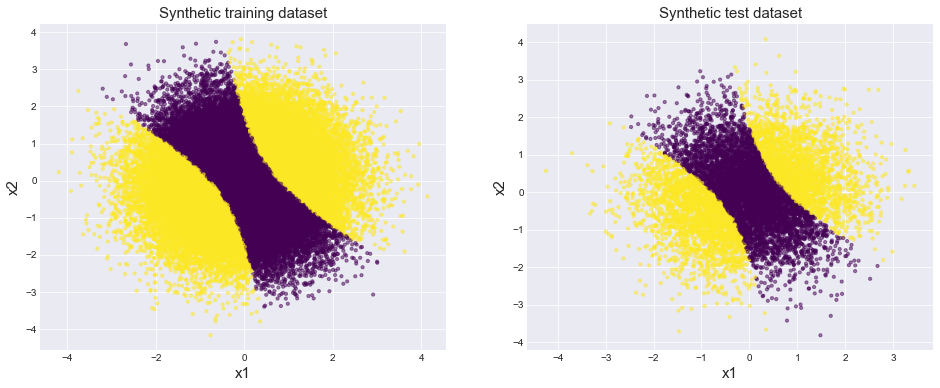

In [42]:
data = load_synth(num_train=60_000, num_val=10_000)
x_train,y_train, x_val,y_val = data[0][0],data[0][1],data[1][0],data[1][1]
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(x_train[:,0],x_train[:,1],c= y_train, cmap = 'viridis',s=10, alpha=0.5)
plt.xlabel('x1',size=15)
plt.ylabel('x2',size=15)
plt.title('Synthetic training dataset',size=15)
# plt.savefig('./plot/Synthetic_dataset.jpg', bbox_inches='tight', dpi=500)
plt.subplot(122)
plt.scatter(x_val[:,0],x_val[:,1],c= y_val, cmap = 'viridis',s=10, alpha=0.5)
plt.xlabel('x1',size=15)
plt.ylabel('x2',size=15)
plt.title('Synthetic test dataset',size=15)
# plt.savefig('./plot/Synthetic_dataset.jpg', bbox_inches='tight', dpi=500)
plt.show()

Fit model

In [14]:
data = load_synth(num_train=60_000, num_val=10_000)
x_train,y_train, x_val,y_val = data[0][0],data[0][1],data[1][0],data[1][1]
y_label = onehot(y_train)
y_val_label = onehot(y_val)

In [15]:
loss, val_loss,t_accc,v_accc,_ = final_model(x_train,y_label,x_val,
                                             y_val_label,learning_rate=1e-3)

In [16]:
mean_t = []
mean_v = []
for i in range(100):
    mean_t.append(mean(loss[i*60000:(i+1)*60000]))
    mean_v.append(mean(val_loss[i*10000:(i+1)*10000]))

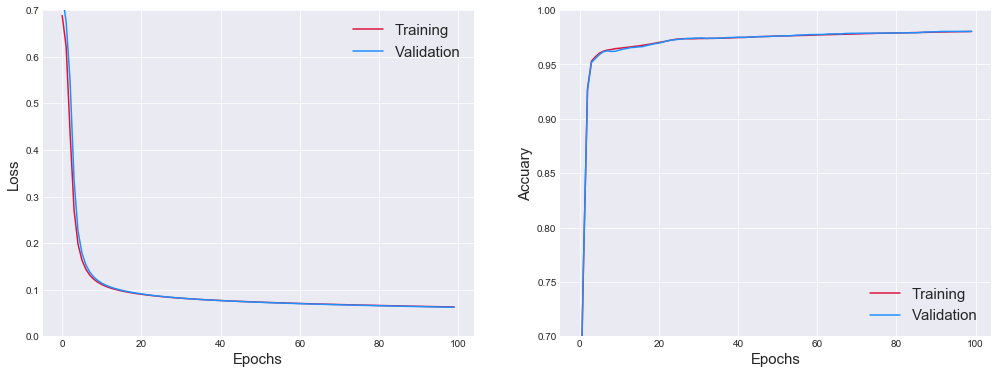

In [17]:
plt.figure(figsize=(17,6))
plt.subplot(121)
plt.plot(mean_t,label ='Training',color='#DC143C')
plt.plot(mean_v,label ='Validation',color = '#1E90FF')
plt.legend(fontsize=15)
plt.ylabel('Loss',size=15)
plt.xlabel('Epochs',size=15)
plt.ylim(0,0.7)
plt.subplot(122)
plt.plot(t_accc,label ='Training',color='#DC143C')
plt.plot(v_accc,label ='Validation',color = '#1E90FF')
# plt.plot(mini_t_a,label ='Training',color='#DC143C')
# plt.plot(mini_v_a,label ='Validation',color = '#1E90FF')
plt.legend(fontsize=15)
plt.ylabel('Accuary',size=15)
plt.xlabel('Epochs',size=15)
plt.ylim(0.7,1)
plt.savefig('./plot/syn.jpg', bbox_inches='tight', dpi=500)
plt.show()

# Part3

Prepare Data

In [36]:
k = load_mnist(final=False, flatten=True)

In [37]:
def normalizing_data(x):
    xx = np.zeros(x.shape)
    for i in range(len(x)):
        xx[i] = (x[i]-np.mean(x[i]))/np.std(x[i])
    return xx

def one_hott(X_training,y_training):
    y_labels = np.zeros((len(X_training),10))
    
    for i in range(len(X_training)):
        y_labels[i][y_training[i]]=1
                   
    return y_labels
    

In [38]:
X_training = k[0][0].astype(dtype=float)
y_training = k[0][1]


X_val = k[1][0].astype(dtype=float)
y_val = k[1][1]

##normalize X
X_training = normalizing_data(X_training)
X_val = normalizing_data(X_val)


## change into one hot
y_labels = one_hott(X_training,y_training)
               
y_val_label = one_hott(X_val,y_val)

model

In [157]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)


def initial_parameter(input_nodes=784,hidden_nodes = 300,output = 10):
    """
    initialize the paramter: W, b, V,c
    
    """
    
    W = np.random.normal(size=(input_nodes,hidden_nodes))
    b = np.zeros(hidden_nodes)
    V = np.random.normal(size=(hidden_nodes,output))
    c = np.zeros(output)
    
    parameter = {"W": W,
             "b": b,
             "V": V,
             "c": c}
    return parameter

def forward_tensor(X_train,parameter):
    """
    Forward
    z1 = x*w+b
    a1 = sigmoid(z1)
    z2 = a1*V+c
    a2 = softmax(z2)
    """

    z1 = np.dot(X_train, parameter['W']) + parameter['b']
    a1 = sigmoid(z1)


    z2 = np.dot(a1, parameter['V']) + parameter['c']
    a2 = softmax(z2)
    
    ##save data
    save = {"z1": z1,
             "a1": a1,
             "z2": z2,
             "a2": a2}
    return a2, save
    
def backward_tensor(parameter, save,X_train, y_label):
    ########## Phase 1

    dloss_dz2 = save['a2'] - y_label
    dz2_dV = save['a1']
    dloss_V = np.dot(dz2_dV.T, dloss_dz2)
    dloss_c = dloss_dz2
    
    ########## Phases 2
    dz2_da1 = parameter['V']
    dloss_da1 = np.dot(dloss_dz2 , dz2_da1.T)
    da1_dz1 = sigmoid_der(save['z1'])
    dz1_dW = X_train
    dloss_W = np.dot(dz1_dW.T, da1_dz1 * dloss_da1)
    dloss_b = dloss_da1 * da1_dz1
    
    gradient = {"dloss_W": dloss_W,
             "dloss_b": dloss_b,
             "dloss_V": dloss_V,
             "dloss_c": dloss_c}
    return gradient

def c_loss(a2,y_label,number):
    loss = np.sum(-y_label * np.log(a2))/number
    return loss
    

def update_parameter(parameter,gradient,learn_rate):
    W = parameter['W']
    b = parameter['b']
    V = parameter['V']
    c = parameter['c']
    
    W -= learn_rate * gradient["dloss_W"]
    b -= learn_rate * gradient["dloss_b"].sum(axis=0)

    V -= learn_rate * gradient["dloss_V"]
    c -= learn_rate * gradient["dloss_c"].sum(axis=0)
    
    parameter = {"W": W,
             "b": b,
             "V": V,
             "c": c}
    return parameter

def predict(parameter,x,target):
    a2,save = forward_tensor(x,parameter)
    number = np.argmax(a2,axis=1)
    accuracy = 0
    for i in range(len(target)):
        if target[i][number[i]] ==1:
            accuracy +=1
            
    accuracy = accuracy/len(a2)
    return accuracy
    
    
    


def Tensor_model(X_training,y_labels,x_val,y_val,learn_rate,batchsize,method):
    parameter = initial_parameter(input_nodes=784,hidden_nodes = 300,output = 10)
    losss =[]
    val_loss = []
    
    train__acc =[]
    val__acc =[]
    
    
    for epoch in range(5):
        
        #### minibatch
        if method == 'batch':
            kk = np.arange(0,len(X_training))
            zz = np.arange(0,len(X_val))
            random.shuffle(kk)
            random.shuffle(zz)
            
            number1 = int(len(X_training)/batchsize)
            number2 = int(len(X_val)/batchsize)
            
            for i in range(number1):
                X_train = X_training[kk[i*batchsize:(i+1)*batchsize]]
                y_label = y_labels[kk[i*batchsize:(i+1)*batchsize]]
                
                a2,save = forward_tensor(X_train,parameter)
                loss = c_loss(a2,y_label,number=number1)
                losss.append(loss)
                
                gradient = backward_tensor(parameter, save,X_train, y_label)
                parameter = update_parameter(parameter,gradient,learn_rate)
                
            for i in range(number2):
                a21,_ = forward_tensor(X_val[zz[i*batchsize:(i+1)*batchsize]],parameter)
                v_loss = c_loss(a21,y_val[zz[i*batchsize:(i+1)*batchsize]],number=number2)
                val_loss.append(v_loss)
                
            train_acc = predict(parameter,X_training,y_labels)
            val_acc = predict(parameter,X_val,y_val)
            train__acc.append(train_acc)
            val__acc.append(val_acc)
                
        ####### SGD
        else:
            ### training
            for i in range(len(X_training)):
                number=1
                X_train = X_training[i].reshape((1,784))
                y_label = y_labels[i].reshape((1,10))
                
                a2,save = forward_tensor(X_train,parameter)
                loss = c_loss(a2,y_label,number=number)
                
                losss.append(loss)
                gradient = backward_tensor(parameter, save,X_train, y_label)
                parameter = update_parameter(parameter,gradient,learn_rate)
            ### validation
            for i in range(len(X_val)):
                number=1
                X_val_s = X_val[i].reshape((1,784))
        
                y_val_s = y_val[i].reshape((1,10))
                
                a21,_ = forward_tensor(X_val_s,parameter)
                v_loss = c_loss(a21,y_val_s,number=number)
                val_loss.append(v_loss)

            ##accuracy
            train_acc = predict(parameter,X_training,y_labels)
            val_acc = predict(parameter,X_val,y_val)
            train__acc.append(train_acc)
            val__acc.append(val_acc)
                
                

    return losss,val_loss,train__acc,val__acc
            
    
def mean_epoch(train_l,val_l):
    mean_train = []
    mean_val = []
    for i in range(5):
        mean_train.append(np.mean(train_l[i*55000:(i+1)*55000]))
        mean_val.append(np.mean(val_l[i*5000:(i+1)*5000]))
    return mean_train,mean_val


def final_prediction(X_training,y_labels,x_val,y_val,learn_rate,number,batchsize):
    parameter = initial_parameter(input_nodes=784,hidden_nodes = 300,output = 10)
    for epoch in range(5):
        ############# forward
        for i in range(batchsize):
            kk =np.random.randint(len(X_training), size=number)
            X_train = X_training[kk]
            y_label = y_labels[kk]

            a2,save = forward_tensor(X_train,parameter)
            loss = c_loss(a2,y_label,number=number)

            gradient = backward_tensor(parameter, save,X_train, y_label)
            parameter = update_parameter(parameter,gradient,learn_rate)
            
    accuracy = predict(parameter,x_val,y_val)
    
    return accuracy 
    
    


SGD

In [108]:
learn_rate = 1e-2
number =1000
batchsize = int(len(X_training)/number)
train_l, val_l,t_acc,v_acc = Tensor_model(X_training,y_labels,X_val,y_val_label,
                        learn_rate,batchsize,method='sto')


In [109]:
mean_train,mean_val = mean_epoch(train_l,val_l)

/Users/hernando/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


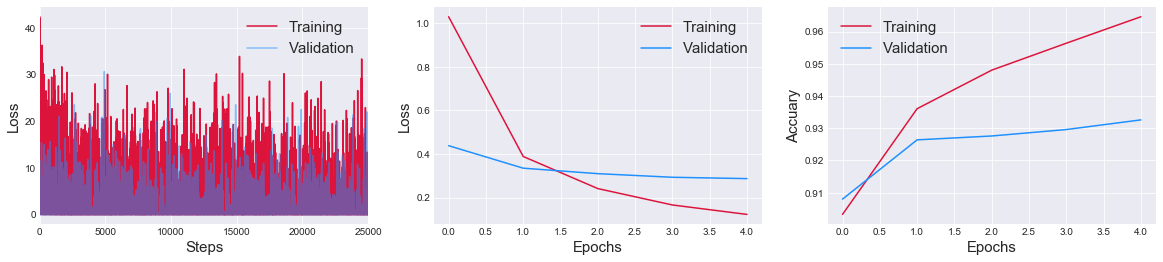

In [111]:
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(train_l,label ='Training',color='#DC143C')
plt.plot(val_l,alpha =0.5,label ='Validation',color = '#1E90FF')
plt.xlabel('Steps',size=15)
plt.ylabel('Loss',size=15)
plt.xlim(0,25000)
plt.legend(fontsize=15)
plt.subplot(132)
plt.plot(mean_train,label ='Training',color='#DC143C')
plt.plot(mean_val,label ='Validation',color = '#1E90FF')
plt.legend(fontsize=15)
plt.ylabel('Loss',size=15)
plt.xlabel('Epochs',size=15)
plt.subplot(133)
plt.plot(t_acc,label ='Training',color='#DC143C')
plt.plot(v_acc,label ='Validation',color = '#1E90FF')
plt.legend(fontsize=15)
plt.ylabel('Accuary',size=15)
plt.xlabel('Epochs',size=15)
plt.savefig('./plot/stooo.jpg', bbox_inches='tight', dpi=500)
plt.show()

Mini-batch

In [173]:
# 1000
# -3
batchsize = 1000
learn_rate = 10e-3
train_loss, val_loss,mini_t_a,mini_v_a = Tensor_model(X_training,y_labels,X_val,y_val_label,
                                    learn_rate,batchsize,method='batch')

In [174]:
number1 = int(len(X_training)/batchsize)
number2 = int(len(X_val)/batchsize)

mean_train_m = []
mean_val_m = []
for i in range(5):
    mean_train_m.append(np.mean(train_loss[i*number1:(i+1)*number1]))
    mean_val_m.append(np.mean(val_loss[i*number2:(i+1)*number2]))

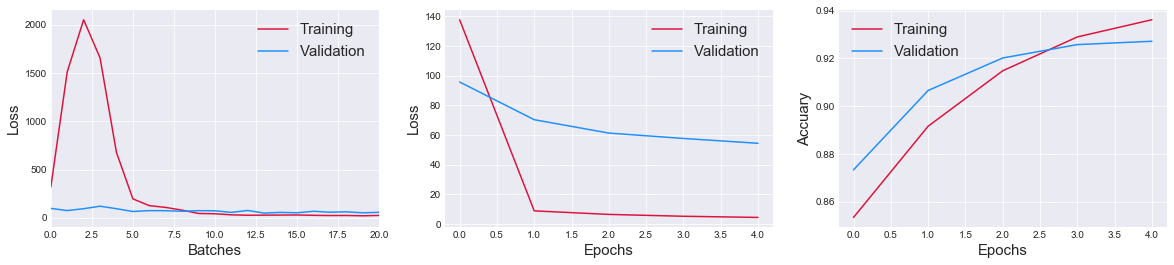

In [176]:
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(train_loss,label ='Training',color='#DC143C')
plt.plot(val_loss,label ='Validation',color = '#1E90FF')
plt.xlabel('Batches',size=15)
plt.ylabel('Loss',size=15)
plt.legend(fontsize=15)
plt.xlim(0,20)
plt.subplot(132)
plt.plot(mean_train_m,label ='Training',color='#DC143C')
plt.plot(mean_val_m,label ='Validation',color = '#1E90FF')
plt.legend(fontsize=15)
plt.ylabel('Loss',size=15)
plt.xlabel('Epochs',size=15)
plt.subplot(133)
plt.plot(mini_t_a,label ='Training',color='#DC143C')
plt.plot(mini_v_a,label ='Validation',color = '#1E90FF')
plt.legend(fontsize=15)
plt.ylabel('Accuary',size=15)
plt.xlabel('Epochs',size=15)
plt.savefig('minibatch.jpg', bbox_inches='tight', dpi=500)
plt.show()

Learning rate + statistic significance

In [97]:
batchsize = 1000
learn_rate = 10e-6
l_6 = []
for i in range(5):
    train_loss, _, mini_t_a,_ = Tensor_model(X_training,y_labels,X_val,y_val_label,
                                        learn_rate,batchsize,method='batch')
    l_6.append([np.array(train_loss),np.array(mini_t_a)])
l_6 = np.array(l_6)

In [177]:
kkkk = [l_3,l_4,l_5,l_6]
labels= ['10e-3','10e-4','10e-5','10e-6']

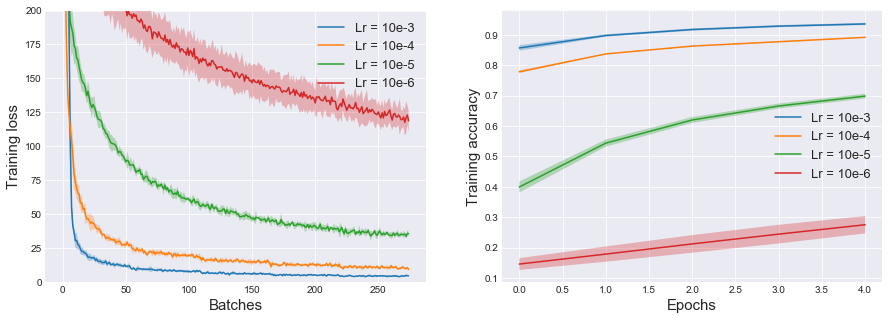

In [178]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for index, i in enumerate(kkkk): 
    plt.plot(np.mean(i[:,0]),label='Lr = '+labels[index])
    plt.fill_between(range(len(i[:,0][0])),(np.mean(i[:,0])+np.std(i[:,0])),(np.mean(i[:,0])-np.std(i[:,0])),alpha=0.3)
plt.xlabel('Batches',size=15)
plt.ylabel('Training loss',size=15)
plt.legend(fontsize=13)
plt.ylim(0,200)
plt.subplot(1,2,2)
for index, i in enumerate(kkkk): 
    plt.plot(np.mean(i[:,1]),label='Lr = '+labels[index])
    plt.fill_between(range(len(i[:,1][0])),(np.mean(i[:,1])+np.std(i[:,1])),(np.mean(i[:,1])-np.std(i[:,1])),alpha=0.3)
plt.xlabel('Epochs',size=15)
plt.ylabel('Training accuracy',size=15)
plt.legend(fontsize=13)
# plt.ylim(0,15)
plt.savefig('training_loss_acc.jpg', bbox_inches='tight', dpi=500)
plt.show()

batchsize

In [124]:
batchsize = 250
learn_rate = 10e-3
b_250 = []
for i in range(5):
    train_loss, _, mini_t_a,_ = Tensor_model(X_training,y_labels,X_val,y_val_label,
                                        learn_rate,batchsize,method='batch')
    b_250.append([np.array(train_loss),np.array(mini_t_a)])
b_250 = np.array(b_250)

In [183]:
zzz = [b_100,b_250,b_500,b_1000]
labels= ['100','250','500','1000']

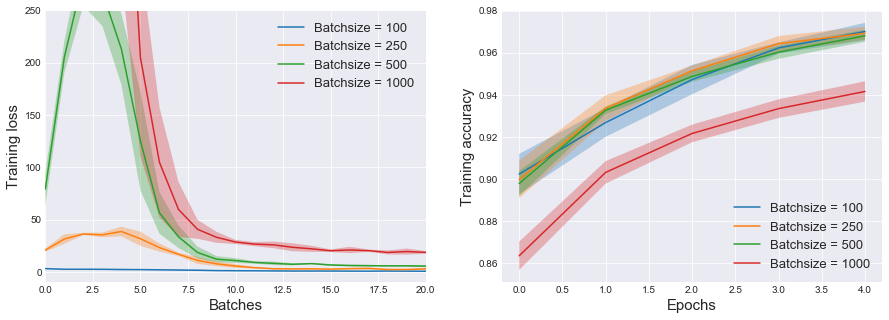

In [184]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for index, i in enumerate(zzz): 
    plt.plot(np.mean(i[:,0]),label='Batchsize = '+labels[index])
    plt.fill_between(range(len(i[:,0][0])),(np.mean(i[:,0])+np.std(i[:,0])),(np.mean(i[:,0])-np.std(i[:,0])),alpha=0.3)
plt.xlabel('Batches',size=15)
plt.ylabel('Training loss',size=15)
plt.legend(fontsize=13)
plt.xlim(0,20)
plt.ylim(-10,250)
plt.subplot(1,2,2)
for index, i in enumerate(zzz): 
    plt.plot(np.mean(i[:,1]),label='Batchsize = '+labels[index])
    plt.fill_between(range(len(i[:,1][0])),(np.mean(i[:,1])+np.std(i[:,1])),(np.mean(i[:,1])-np.std(i[:,1])),alpha=0.3)
plt.xlabel('Epochs',size=15)
plt.ylabel('Training accuracy',size=15)
plt.legend(fontsize=13)
# plt.ylim(0,15)
plt.savefig('training_batches.jpg', bbox_inches='tight', dpi=500)
plt.show()

Final prediction

In [66]:
zzz = load_mnist(final=True, flatten=True)

In [67]:
final_x_train = normalizing_data(zzz[0][0])
final_x_test = normalizing_data(zzz[1][0])
final_y_train = one_hott(final_x_train,zzz[0][1])
final_y_test = one_hott(final_x_test,zzz[1][1])       

In [151]:
batchsize = 500
number =int(len(final_x_train)/batchsize)
learn_rate = 10e-3
accuracy = final_prediction(final_x_train,final_y_train,final_x_test,final_y_test,learn_rate,number,batchsize)

In [152]:
accuracy

0.9314